In [1]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)


In [2]:
import  os
movie_line = os.path.join(os.getcwd(), '../Datasets/cornell movie-dialogs corpus/movie_lines.txt')
movie_convo = os.path.join(os.getcwd(), '../Datasets/cornell movie-dialogs corpus/movie_conversations.txt')

In [3]:
lines = open(movie_line , encoding='utf-8',errors='ignore').read().split('\n')
conv_lines = open(movie_convo , encoding='utf-8',errors='ignore').read().split('\n')

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

In [4]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]


[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]

In [5]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


In [6]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [7]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

In [8]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [9]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


In [10]:
# Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [11]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)


114938

In [16]:
import zipfile

file_list = ['glove.6B.zip']


Extract_flag = 'y'

if Extract_flag in ["y", "Y", "Yes", "yes"]:

  for file in file_list:
    
    zip_path = file
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall()
    print(f"Done extracting {zip_path}\n")

Done extracting glove.6B.zip




Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.


In [17]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test) #this returns TRUE

Loading glove...
GloVe  50  loded!


In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        #  pass the embedding into a bidirectional version of the GRU - as you can see in the call() method below, you can use just 1 GRU layer but could experiment with more
        self.embeddings = embeddings

        # self.Bidirectional1 = Bidirectional(GRU(enc_units, return_sequences = True))
        self.Bidirectional2 = Bidirectional(GRU(enc_units, return_state = True, return_sequences = True))

        # dropout                                                                                   
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        # x = self.dropout(x)
        # x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f, state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [19]:
encoder = Encoder(vocab_len, 50, GRU_units)

In [21]:
GRU_units

50

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query = dec_hidden =  Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b]) = (forward and backward contexts from encoder biGRU)
        # values = enc_output (The sequence output from the encoder GRU)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        self.dropout = Dropout(0.2)
        # Create the decoder with attention - as you'll see in the call() method below, it will need two GRU layers

        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = GRU(self.units, return_sequences = True)
        self.decoder_gru_l2 = GRU(self.units , return_state = True, return_sequences = False)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # produces the weighted contexts and the attention weights
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together
        # print(f"After concatenating attention: {x.shape}")

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        # print(f"decoder_gru_l1: {x.shape}")

        # Appy dropout
        x = self.dropout(x)
        # print(f"dropout: {x.shape}")

        #Apply last GRU
        output, state = self.decoder_gru_l2(x)
        # print(f"decoder_gru_l2: Out = {output.shape}, state = {state.shape}")

        #Generate output
        x = self.fc(output)
        return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_len, 50, GRU_units)

In [25]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence, return_pred_len = False):
    
    if len(sentence) > 9:
      fig = plt.figure(figsize=(10,10))
    elif len(sentence) > 7:
      fig = plt.figure(figsize=(8,8))
    else:
      fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 10}

    for (i, j), z in np.ndenumerate(attention):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))


    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

    if return_pred_len:
      return len(predicted_sentence)


def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False, return_pred_len = False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]

    if return_pred_len:
       pred_length = plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1], return_pred_len = True)
       return pred_length
    else:
      plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

In [26]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

In [27]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [34]:
checkpoint_dir = './training_checkpoints_Final_Model'
checkpoint_prefix = os.path.join(checkpoint_dir+'/'+str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [35]:
checkpoint_prefix

'./training_checkpoints_Final_Model/50-ckpt'

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):

            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [31]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 141 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


In [32]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

In [36]:
checkpoint.restore(checkpoint_dir + '/' + str(emb_dim) + "-ckpt-140")
test_bot()
print(encoder.summary())
print(decoder.summary())

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  725000    
                                                                 
 bidirectional (Bidirectiona  multiple                 30600     
 l)                                                              
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 755,600
Trainable params: 30,600
Non-trainable params: 725,000
_________________

Epoch 1 Batch 598 Loss: 1.4116
Epoch 1 Batch 1196 Loss: 1.5836
Epoch 1 Batch 1794 Loss: 1.5736
Epoch 1 Batch 2392 Loss: 1.6449
Epoch 1 Batch 2990 Loss: 1.3778
Epoch 1 Batch 3588 Loss: 1.3070

*** Epoch 1 Loss 1.4742 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  1
Time  797.736 sec

Epoch 2 Batch 598 Loss: 1.3923
Epoch 2 Batch 1196 Loss: 1.7759
Epoch 2 Batch 1794 Loss: 1.9070
Epoch 2 Batch 2392 Loss: 1.9596
Epoch 2 Batch 2990 Loss: 1.4571
Epoch 2 Batch 3588 Loss: 1.6857

*** Epoch 2 Loss 1.4774 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i 

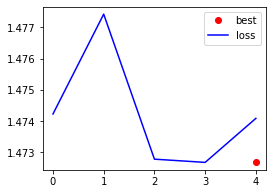

Best epoch so far:  4
Time  822.947 sec

Epoch 6 Batch 598 Loss: 1.3606
Epoch 6 Batch 1196 Loss: 1.6161
Epoch 6 Batch 1794 Loss: 1.5511
Epoch 6 Batch 2392 Loss: 1.6536
Epoch 6 Batch 2990 Loss: 1.3428
Epoch 6 Batch 3588 Loss: 1.3932

*** Epoch 6 Loss 1.4714 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  6
Time  828.379 sec

Epoch 7 Batch 598 Loss: 1.4493
Epoch 7 Batch 1196 Loss: 1.7109
Epoch 7 Batch 1794 Loss: 1.8739
Epoch 7 Batch 2392 Loss: 1.9744
Epoch 7 Batch 2990 Loss: 1.3416
Epoch 7 Batch 3588 Loss: 1.6327

*** Epoch 7 Loss 1.4723 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure i am not sure i am not s

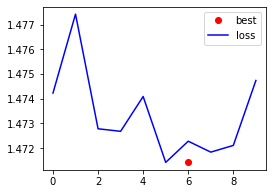

Best epoch so far:  6
Time  848.832 sec

Epoch 11 Batch 598 Loss: 1.3806
Epoch 11 Batch 1196 Loss: 1.6870
Epoch 11 Batch 1794 Loss: 1.5013
Epoch 11 Batch 2392 Loss: 1.6919
Epoch 11 Batch 2990 Loss: 1.3638
Epoch 11 Batch 3588 Loss: 1.4929

*** Epoch 11 Loss 1.4711 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  11
Time  855.410 sec

Epoch 12 Batch 598 Loss: 1.4614
Epoch 12 Batch 1196 Loss: 1.7035
Epoch 12 Batch 1794 Loss: 1.8066
Epoch 12 Batch 2392 Loss: 1.9601
Epoch 12 Batch 2990 Loss: 1.3108
Epoch 12 Batch 3588 Loss: 1.5866

*** Epoch 12 Loss 1.4716 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure

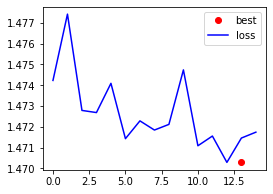

Best epoch so far:  13
Time  850.533 sec

Epoch 16 Batch 598 Loss: 1.3028
Epoch 16 Batch 1196 Loss: 1.6922
Epoch 16 Batch 1794 Loss: 1.5271
Epoch 16 Batch 2392 Loss: 1.7469
Epoch 16 Batch 2990 Loss: 1.3962
Epoch 16 Batch 3588 Loss: 1.5094

*** Epoch 16 Loss 1.4698 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  16
Time  942.175 sec

Epoch 17 Batch 598 Loss: 1.3999
Epoch 17 Batch 1196 Loss: 1.5967
Epoch 17 Batch 1794 Loss: 1.5739
Epoch 17 Batch 2392 Loss: 1.6235
Epoch 17 Batch 2990 Loss: 1.3819
Epoch 17 Batch 3588 Loss: 1.2957

*** Epoch 17 Loss 1.4701 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
G

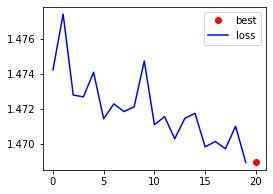

Best epoch so far:  20
Time  880.893 sec

Epoch 21 Batch 598 Loss: 1.2698
Epoch 21 Batch 1196 Loss: 1.8155
Epoch 21 Batch 1794 Loss: 1.6836
Epoch 21 Batch 2392 Loss: 1.7931
Epoch 21 Batch 2990 Loss: 1.4486
Epoch 21 Batch 3588 Loss: 1.6027

*** Epoch 21 Loss 1.4723 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  20
Time  962.983 sec

Epoch 22 Batch 598 Loss: 1.3512
Epoch 22 Batch 1196 Loss: 1.6370
Epoch 22 Batch 1794 Loss: 1.5519
Epoch 22 Batch 2392 Loss: 1.6571
Epoch 22 Batch 2990 Loss: 1.3336
Epoch 22 Batch 3588 Loss: 1.3820

*** Epoch 22 Loss 1.4683 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy|

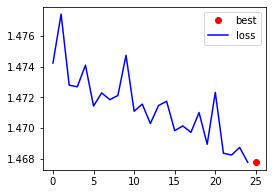

Best epoch so far:  25
Time  750.058 sec

Epoch 26 Batch 598 Loss: 1.3387
Epoch 26 Batch 1196 Loss: 1.8273
Epoch 26 Batch 1794 Loss: 1.7951
Epoch 26 Batch 2392 Loss: 1.7133
Epoch 26 Batch 2990 Loss: 1.4886
Epoch 26 Batch 3588 Loss: 1.6634

*** Epoch 26 Loss 1.4688 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  25
Time  711.543 sec

Epoch 27 Batch 598 Loss: 1.3766
Epoch 27 Batch 1196 Loss: 1.6542
Epoch 27 Batch 1794 Loss: 1.5075
Epoch 27 Batch 2392 Loss: 1.6926
Epoch 27 Batch 2990 Loss: 1.3561
Epoch 27 Batch 3588 Loss: 1.5035

*** Epoch 27 Loss 1.4685 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: Wha

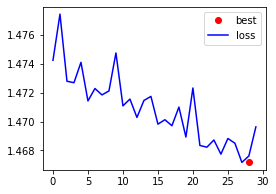

Best epoch so far:  28
Time  725.886 sec

Epoch 31 Batch 598 Loss: 1.1956
Epoch 31 Batch 1196 Loss: 1.9393
Epoch 31 Batch 1794 Loss: 1.7580
Epoch 31 Batch 2392 Loss: 1.8448
Epoch 31 Batch 2990 Loss: 1.4594
Epoch 31 Batch 3588 Loss: 1.7163

*** Epoch 31 Loss 1.4675 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  28
Time  710.338 sec

Epoch 32 Batch 598 Loss: 1.2946
Epoch 32 Batch 1196 Loss: 1.6989
Epoch 32 Batch 1794 Loss: 1.5437
Epoch 32 Batch 2392 Loss: 1.7656
Epoch 32 Batch 2990 Loss: 1.3849
Epoch 32 Batch 3588 Loss: 1.4713

*** Epoch 32 Loss 1.4677 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy|

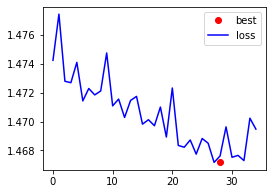

Best epoch so far:  28
Time  756.431 sec

Epoch 36 Batch 598 Loss: 1.2367
Epoch 36 Batch 1196 Loss: 1.9702
Epoch 36 Batch 1794 Loss: 1.7575
Epoch 36 Batch 2392 Loss: 1.8537
Epoch 36 Batch 2990 Loss: 1.4915
Epoch 36 Batch 3588 Loss: 1.6829

*** Epoch 36 Loss 1.4674 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
Best epoch so far:  28
Time  734.473 sec

Epoch 37 Batch 598 Loss: 1.2916
Epoch 37 Batch 1196 Loss: 1.7337
Epoch 37 Batch 1794 Loss: 1.6851
Epoch 37 Batch 2392 Loss: 1.7818
Epoch 37 Batch 2990 Loss: 1.4262
Epoch 37 Batch 3588 Loss: 1.5949

*** Epoch 37 Loss 1.4678 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: Wh

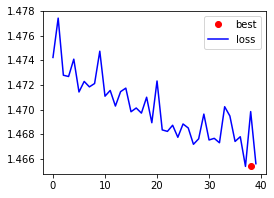

Best epoch so far:  38
Time  29334.917 sec

Epoch 41 Batch 598 Loss: 1.3127
Epoch 41 Batch 1196 Loss: 1.9174
Epoch 41 Batch 1794 Loss: 1.9242
Epoch 41 Batch 2392 Loss: 1.8287
Epoch 41 Batch 2990 Loss: 1.4984
Epoch 41 Batch 3588 Loss: 1.6920

*** Epoch 41 Loss 1.4659 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  38
Time  717.212 sec

Epoch 42 Batch 598 Loss: 1.3400
Epoch 42 Batch 1196 Loss: 1.7917
Epoch 42 Batch 1794 Loss: 1.8065
Epoch 42 Batch 2392 Loss: 1.6876
Epoch 42 Batch 2990 Loss: 1.4749
Epoch 42 Batch 3588 Loss: 1.6930

*** Epoch 42 Loss 1.4656 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greed

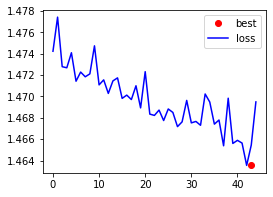

Best epoch so far:  43
Time  754.898 sec

Epoch 46 Batch 598 Loss: 1.3618
Epoch 46 Batch 1196 Loss: 1.8704
Epoch 46 Batch 1794 Loss: 1.8713
Epoch 46 Batch 2392 Loss: 1.8301
Epoch 46 Batch 2990 Loss: 1.4706
Epoch 46 Batch 3588 Loss: 1.7327

*** Epoch 46 Loss 1.4658 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  43
Time  766.199 sec

Epoch 47 Batch 598 Loss: 1.1854
Epoch 47 Batch 1196 Loss: 1.9523
Epoch 47 Batch 1794 Loss: 1.7585
Epoch 47 Batch 2392 Loss: 1.8252
Epoch 47 Batch 2990 Loss: 1.4601
Epoch 47 Batch 3588 Loss: 1.7166

*** Epoch 47 Loss 1.4664 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Gree

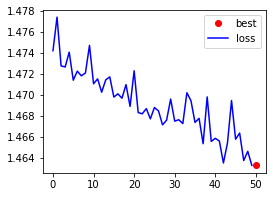

Best epoch so far:  50
Time  701.137 sec

Epoch 51 Batch 598 Loss: 1.3643
Epoch 51 Batch 1196 Loss: 1.9445
Epoch 51 Batch 1794 Loss: 1.8866
Epoch 51 Batch 2392 Loss: 1.9604
Epoch 51 Batch 2990 Loss: 1.4450
Epoch 51 Batch 3588 Loss: 1.8504

*** Epoch 51 Loss 1.4640 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  50
Time  9707.497 sec

Epoch 52 Batch 598 Loss: 1.2508
Epoch 52 Batch 1196 Loss: 1.9893
Epoch 52 Batch 1794 Loss: 1.7617
Epoch 52 Batch 2392 Loss: 1.8325
Epoch 52 Batch 2990 Loss: 1.4626
Epoch 52 Batch 3588 Loss: 1.6696

*** Epoch 52 Loss 1.4649 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: Wh

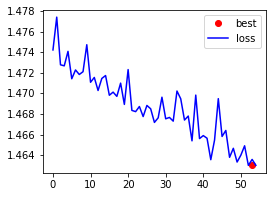

Best epoch so far:  53
Time  763.786 sec

Epoch 56 Batch 598 Loss: 1.4021
Epoch 56 Batch 1196 Loss: 1.8765
Epoch 56 Batch 1794 Loss: 1.8904
Epoch 56 Batch 2392 Loss: 1.9798
Epoch 56 Batch 2990 Loss: 1.4736
Epoch 56 Batch 3588 Loss: 1.7368

*** Epoch 56 Loss 1.4667 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am placing 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
Best epoch so far:  53
Time  781.238 sec

Epoch 57 Batch 598 Loss: 1.2930
Epoch 57 Batch 1196 Loss: 1.9213
Epoch 57 Batch 1794 Loss: 1.9164
Epoch 57 Batch 2392 Loss: 1.8384
Epoch 57 Batch 2990 Loss: 1.4875
Epoch 57 Batch 3588 Loss: 1.7104

*** Epoch 57 Loss 1.4629 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going

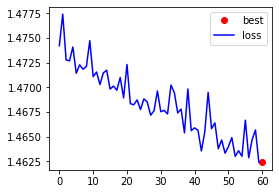

Best epoch so far:  60
Time  779.788 sec

Epoch 61 Batch 598 Loss: 1.3887
Epoch 61 Batch 1196 Loss: 1.8592
Epoch 61 Batch 1794 Loss: 1.8337
Epoch 61 Batch 2392 Loss: 1.9733
Epoch 61 Batch 2990 Loss: 1.4991
Epoch 61 Batch 3588 Loss: 1.7419

*** Epoch 61 Loss 1.4666 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  60
Time  967.353 sec

Epoch 62 Batch 598 Loss: 1.3597
Epoch 62 Batch 1196 Loss: 1.8739
Epoch 62 Batch 1794 Loss: 1.8933
Epoch 62 Batch 2392 Loss: 1.8188
Epoch 62 Batch 2990 Loss: 1.4493
Epoch 62 Batch 3588 Loss: 1.7357

*** Epoch 62 Loss 1.4628 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy|

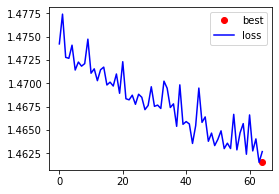

Best epoch so far:  64
Time  836.790 sec

Epoch 66 Batch 598 Loss: 1.3971
Epoch 66 Batch 1196 Loss: 1.7180
Epoch 66 Batch 1794 Loss: 1.8756
Epoch 66 Batch 2392 Loss: 1.9562
Epoch 66 Batch 2990 Loss: 1.3919
Epoch 66 Batch 3588 Loss: 1.6823

*** Epoch 66 Loss 1.4615 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to communicate to improve 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  66
Time  812.582 sec

Epoch 67 Batch 598 Loss: 1.3625
Epoch 67 Batch 1196 Loss: 1.9191
Epoch 67 Batch 1794 Loss: 1.8874
Epoch 67 Batch 2392 Loss: 1.9466
Epoch 67 Batch 2990 Loss: 1.4446
Epoch 67 Batch 3588 Loss: 1.8468

*** Epoch 67 Loss 1.4618 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to d

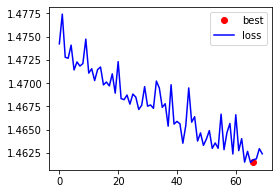

Best epoch so far:  66
Time  738.339 sec

Epoch 71 Batch 598 Loss: 1.4293
Epoch 71 Batch 1196 Loss: 1.7112
Epoch 71 Batch 1794 Loss: 1.8542
Epoch 71 Batch 2392 Loss: 1.9459
Epoch 71 Batch 2990 Loss: 1.2923
Epoch 71 Batch 3588 Loss: 1.6241

*** Epoch 71 Loss 1.4610 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
check point saved!
Best epoch so far:  71
Time  724.910 sec

Epoch 72 Batch 598 Loss: 1.3955
Epoch 72 Batch 1196 Loss: 1.8566
Epoch 72 Batch 1794 Loss: 1.8573
Epoch 72 Batch 2392 Loss: 1.9400
Epoch 72 Batch 2990 Loss: 1.4537
Epoch 72 Batch 3588 Loss: 1.7294

*** Epoch 72 Loss 1.4614 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i a

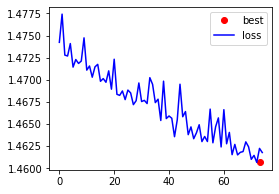

Best epoch so far:  73
Time  8215.422 sec

Epoch 76 Batch 598 Loss: 1.4775
Epoch 76 Batch 1196 Loss: 1.7074
Epoch 76 Batch 1794 Loss: 1.7959
Epoch 76 Batch 2392 Loss: 1.9555
Epoch 76 Batch 2990 Loss: 1.2610
Epoch 76 Batch 3588 Loss: 1.5848

*** Epoch 76 Loss 1.4617 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  73
Time  635.654 sec

Epoch 77 Batch 598 Loss: 1.3897
Epoch 77 Batch 1196 Loss: 1.7919
Epoch 77 Batch 1794 Loss: 1.8370
Epoch 77 Batch 2392 Loss: 1.9730
Epoch 77 Batch 2990 Loss: 1.4699
Epoch 77 Batch 3588 Loss: 1.7224

*** Epoch 77 Loss 1.4605 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not goi

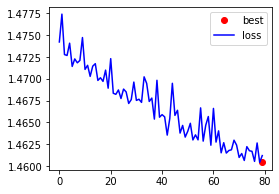

Best epoch so far:  79
Time  10346.966 sec

Epoch 81 Batch 598 Loss: 1.3766
Epoch 81 Batch 1196 Loss: 1.5580
Epoch 81 Batch 1794 Loss: 1.5568
Epoch 81 Batch 2392 Loss: 1.6236
Epoch 81 Batch 2990 Loss: 1.3379
Epoch 81 Batch 3588 Loss: 1.2869

*** Epoch 81 Loss 1.4587 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not gonna do it 
####################
check point saved!
Best epoch so far:  81
Time  706.498 sec

Epoch 82 Batch 598 Loss: 1.4044
Epoch 82 Batch 1196 Loss: 1.7111
Epoch 82 Batch 1794 Loss: 1.8832
Epoch 82 Batch 2392 Loss: 1.9645
Epoch 82 Batch 2990 Loss: 1.4129
Epoch 82 Batch 3588 Loss: 1.6833

*** Epoch 82 Loss 1.4617 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am no

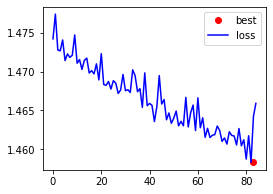

Best epoch so far:  83
Time  785.226 sec

Epoch 86 Batch 598 Loss: 1.3482
Epoch 86 Batch 1196 Loss: 1.6015
Epoch 86 Batch 1794 Loss: 1.5292
Epoch 86 Batch 2392 Loss: 1.6642
Epoch 86 Batch 2990 Loss: 1.2883
Epoch 86 Batch 3588 Loss: 1.3670

*** Epoch 86 Loss 1.4584 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do not know 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
Best epoch so far:  83
Time  775.449 sec

Epoch 87 Batch 598 Loss: 1.4237
Epoch 87 Batch 1196 Loss: 1.6908
Epoch 87 Batch 1794 Loss: 1.8639
Epoch 87 Batch 2392 Loss: 1.9413
Epoch 87 Batch 2990 Loss: 1.3055
Epoch 87 Batch 3588 Loss: 1.6303

*** Epoch 87 Loss 1.4607 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am

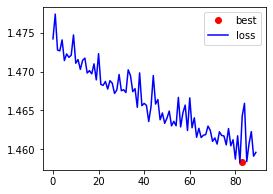

Best epoch so far:  83
Time  6741.875 sec

Epoch 91 Batch 598 Loss: 1.3793
Epoch 91 Batch 1196 Loss: 1.6267
Epoch 91 Batch 1794 Loss: 1.5111
Epoch 91 Batch 2392 Loss: 1.6881
Epoch 91 Batch 2990 Loss: 1.3299
Epoch 91 Batch 3588 Loss: 1.4855

*** Epoch 91 Loss 1.4586 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  83
Time  711.744 sec

Epoch 92 Batch 598 Loss: 1.4548
Epoch 92 Batch 1196 Loss: 1.7161
Epoch 92 Batch 1794 Loss: 1.7922
Epoch 92 Batch 2392 Loss: 1.9763
Epoch 92 Batch 2990 Loss: 1.2370
Epoch 92 Batch 3588 Loss: 1.5996

*** Epoch 92 Loss 1.4613 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am

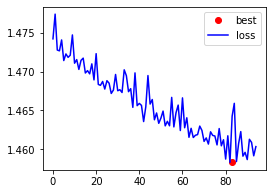

Best epoch so far:  83
Time  696.649 sec

Epoch 96 Batch 598 Loss: 1.2882
Epoch 96 Batch 1196 Loss: 1.6734
Epoch 96 Batch 1794 Loss: 1.5439
Epoch 96 Batch 2392 Loss: 1.7530
Epoch 96 Batch 2990 Loss: 1.3566
Epoch 96 Batch 3588 Loss: 1.4763

*** Epoch 96 Loss 1.4593 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  83
Time  809.816 sec

Epoch 97 Batch 598 Loss: 1.4018
Epoch 97 Batch 1196 Loss: 1.5575
Epoch 97 Batch 1794 Loss: 1.5701
Epoch 97 Batch 2392 Loss: 1.6278
Epoch 97 Batch 2990 Loss: 1.3622
Epoch 97 Batch 3588 Loss: 1.2855

*** Epoch 97 Loss 1.4635 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not 

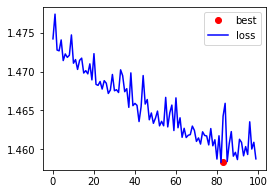

Best epoch so far:  83
Time  708.344 sec

Epoch 101 Batch 598 Loss: 1.2624
Epoch 101 Batch 1196 Loss: 1.7203
Epoch 101 Batch 1794 Loss: 1.6973
Epoch 101 Batch 2392 Loss: 1.7693
Epoch 101 Batch 2990 Loss: 1.4033
Epoch 101 Batch 3588 Loss: 1.6098

*** Epoch 101 Loss 1.4571 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  101
Time  717.095 sec

Epoch 102 Batch 598 Loss: 1.3649
Epoch 102 Batch 1196 Loss: 1.6080
Epoch 102 Batch 1794 Loss: 1.5883
Epoch 102 Batch 2392 Loss: 1.6654
Epoch 102 Batch 2990 Loss: 1.3020
Epoch 102 Batch 3588 Loss: 1.3953

*** Epoch 102 Loss 1.4593 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: 

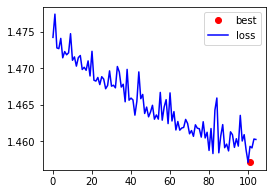

Best epoch so far:  101
Time  676.507 sec

Epoch 106 Batch 598 Loss: 1.3332
Epoch 106 Batch 1196 Loss: 1.8163
Epoch 106 Batch 1794 Loss: 1.7870
Epoch 106 Batch 2392 Loss: 1.7041
Epoch 106 Batch 2990 Loss: 1.4715
Epoch 106 Batch 3588 Loss: 1.7012

*** Epoch 106 Loss 1.4605 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to communicate to settle 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  101
Time  36208.589 sec

Epoch 107 Batch 598 Loss: 1.3669
Epoch 107 Batch 1196 Loss: 1.6294
Epoch 107 Batch 1794 Loss: 1.4977
Epoch 107 Batch 2392 Loss: 1.6973
Epoch 107 Batch 2990 Loss: 1.3477
Epoch 107 Batch 3588 Loss: 1.4669

*** Epoch 107 Loss 1.4611 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to communicate to know 
%
Gr

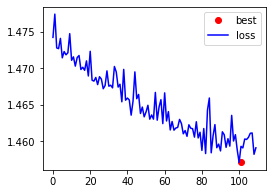

Best epoch so far:  101
Time  732.319 sec

Epoch 111 Batch 598 Loss: 1.1890
Epoch 111 Batch 1196 Loss: 1.9670
Epoch 111 Batch 1794 Loss: 1.7732
Epoch 111 Batch 2392 Loss: 1.8005
Epoch 111 Batch 2990 Loss: 1.4381
Epoch 111 Batch 3588 Loss: 1.7144

*** Epoch 111 Loss 1.4640 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to communicate 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  101
Time  696.982 sec

Epoch 112 Batch 598 Loss: 1.2883
Epoch 112 Batch 1196 Loss: 1.6720
Epoch 112 Batch 1794 Loss: 1.5183
Epoch 112 Batch 2392 Loss: 1.8449
Epoch 112 Batch 2990 Loss: 1.3602
Epoch 112 Batch 3588 Loss: 1.4677

*** Epoch 112 Loss 1.4611 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: Wh

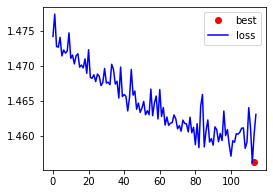

Best epoch so far:  113
Time  790.203 sec

Epoch 116 Batch 598 Loss: 1.2284
Epoch 116 Batch 1196 Loss: 1.9665
Epoch 116 Batch 1794 Loss: 1.7389
Epoch 116 Batch 2392 Loss: 1.8248
Epoch 116 Batch 2990 Loss: 1.4497
Epoch 116 Batch 3588 Loss: 1.7124

*** Epoch 116 Loss 1.4580 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not gonna do 
####################
Best epoch so far:  113
Time  812.726 sec

Epoch 117 Batch 598 Loss: 1.2618
Epoch 117 Batch 1196 Loss: 1.7491
Epoch 117 Batch 1794 Loss: 1.6766
Epoch 117 Batch 2392 Loss: 1.7635
Epoch 117 Batch 2990 Loss: 1.4155
Epoch 117 Batch 3588 Loss: 1.6057

*** Epoch 117 Loss 1.4611 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: 

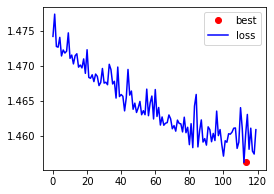

Best epoch so far:  113
Time  832.309 sec

Epoch 121 Batch 598 Loss: 1.2808
Epoch 121 Batch 1196 Loss: 1.9231
Epoch 121 Batch 1794 Loss: 1.8950
Epoch 121 Batch 2392 Loss: 1.8346
Epoch 121 Batch 2990 Loss: 1.4849
Epoch 121 Batch 3588 Loss: 1.6989

*** Epoch 121 Loss 1.4588 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to communicate to attract me 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  113
Time  13968.043 sec

Epoch 122 Batch 598 Loss: 1.3142
Epoch 122 Batch 1196 Loss: 1.8237
Epoch 122 Batch 1794 Loss: 1.7753
Epoch 122 Batch 2392 Loss: 1.7182
Epoch 122 Batch 2990 Loss: 1.4494
Epoch 122 Batch 3588 Loss: 1.6801

*** Epoch 122 Loss 1.4576 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are 

KeyboardInterrupt: 

In [37]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

In [ ]:
current_ep = 94

checkpoint.restore(checkpoint_dir + '/' + str(emb_dim) + "-ckpt-"+ str(current_ep-1))

test_bot()

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

In [ ]:
def print_examples(chkpnt_list, q_list):


  p_len_list = []
  Q_count = 1
  for chkpnt in chkpnt_list:
    checkpoint.restore(checkpoint_dir + '/' + str(emb_dim) + "-ckpt-"+ str(chkpnt))
    for q in q_list:
      print("#"+"="*20+"#")
      print(f"Question {Q_count}")
      print("#"+"="*20+"#") 
      p_len = answer(q, training=False, return_pred_len = True)
      p_len_list.append(p_len)    
      Q_count+=1
      
    print("#"+"="*30+"#")
    print(f"Average prediction length: {sum(p_len_list)/len(p_len_list)}")
    print("#"+"="*30+"#")


q_list = ["Can you play me a sad song",
          "How much money should I deposit into my bank account",

          "Did you finish the game",
          "Did you finish the game that you played last week",

          "Do you believe I saw a man with binoculars",
          "Should I go to New York next year",

          "is a king usually a man",
          "What is your name",

          "Good day do think I should go to the mall this morning or later in the afternoon",
          "Would now be a good time to talk to you or would you prefer to talk later",

          ]


In [ ]:
print_examples([5], q_list)

In [ ]:
print_examples([50], q_list)

In [ ]:
print_examples([140], q_list)